In [11]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.regularizers import l2
from keras.utils import to_categorical

from sklearn.metrics import confusion_matrix, classification_report


from collections import Counter
from sklearn import linear_model
import numpy as np

import matplotlib.pyplot as plt

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids

from util import (
    readData,
    createDesignMatrix,
    createLabelVector,
    printM,
    splitData7030,
    splitUpDataCrossVal,
    featureNormalize,
    multiclassToBinaryClass,
    ACTIVE_DATASET,
    TRAINING_PARAMS
)

from plotCallback import (PlotLossAccuracy)

NUM_CLASSES = 10

In [ ]:
# Over sample the minority classes
# NOTE: SHOULD OVERSAMPLE AFTER SPLITTING DATA NOT BEFORE
# OTHERWISE JUST LEARNING THE VALIDATION SET TOO
def splitAndOverSample(X, y, numDataSplits=None, crossValIndex=None):

    # Split the data
    if numDataSplits:
        xTrain, yTrain, xVal, yVal = splitUpDataCrossVal(X, y, numDataSplits, crossValIndex)
    else:
        xTrain, yTrain, xVal, yVal = splitData7030(X, y)

    # If no sampling to be done
    if not TRAINING_PARAMS['BALANCE_SAMPLING']:

        ## Binary encode the classes data
        yTrain = to_categorical(yTrain, num_classes=NUM_CLASSES)
        yVal = to_categorical(yVal, num_classes=NUM_CLASSES)
        print("After binary encoding y: ", yTrain.shape)
        return  xTrain, yTrain, xVal, yVal
    else:
        counts = Counter(yTrain)

        if TRAINING_PARAMS['BALANCE_SAMPLING'] == 'OVER':

            # Define oversampling amounts
            ratioDict = {3: max(20, counts[3]), 4: max(80, counts[4]), 5: counts[5],
                         6: counts[6], 7: counts[7], 8: max(80, counts[8]), 9: max(20, counts[9])}

            # Oversample the training data
            xTrainOS, yTrainOS = RandomOverSampler(random_state=0, ratio=ratioDict).fit_sample(xTrain, yTrain)
            # xTrainOS, yTrainOS = SMOTE(k_neighbors=3, ratio=ratioDict).fit_sample(xTrain, yTrain)
            # xTrainOS, yTrainOS = ADASYN(n_neighbors=4, ratio=ratioDict).fit_sample(xTrain, yTrain)

            print('Oversampling')
            print('Rating distribution: ', sorted(Counter(yTrainOS).items()))

            # Show distribution of classes after over sampling
            plt.hist([yTrain, yTrainOS], bins=range(3, 11), align='left', rwidth=0.5, label=['No Oversampling', 'Oversampling'])
            plt.legend()
            plt.show()

            # Binary encode
            yTrainOS = to_categorical(yTrainOS, num_classes=10)
            yVal = to_categorical(yVal, num_classes=10)
            print("After binary encoding y: ", yTrainOS.shape)

            return xTrainOS, yTrainOS, xVal, yVal
        else:
            ratioDict = {3: counts[3], 4: counts[4], 5: min(counts[5], 400),
                         6: min(counts[6], 800), 7: min(counts[7], 400), 8: counts[8], 9: counts[9]}
            xTrainUS, yTrainUS = RandomUnderSampler(random_state=0, ratio=ratioDict).fit_sample(xTrain, yTrain)

            print('Using Undersampling')
            print('Category distribution: ', sorted(Counter(yTrainUS).items()))

            # Show distribution of classes after under sampling
            plt.hist([yTrain, yTrainUS], bins=range(3, 11), align='left', rwidth=0.5, label=['No Undersampling', 'Undersampling'])
            plt.legend()
            plt.show()

            # Binary encode
            yTrainUS = to_categorical(yTrainUS, num_classes=10)
            yVal = to_categorical(yVal, num_classes=10)
            print("After binary encoding y: ", yTrainUS.shape)

            return xTrainUS, yTrainUS, xVal, yVal


In [ ]:

data = readData()
X = createDesignMatrix(data)
X = featureNormalize(X)

y = createLabelVector(data)
y = np.squeeze(np.asarray(y))
print("X: ", X.shape)
print("y: ", y.shape)


# print(X)
# print(y)
# np.savetxt("split.csv", yTrain)

data = readData(filename='testData.csv')
xTest = createDesignMatrix(data)
xTest = featureNormalize(xTest)

yTest = createLabelVector(data)
yTest = np.squeeze(np.asarray(yTest))
yTest = to_categorical(yTest, num_classes=10)


In [ ]:



# Define the network
model = Sequential()

model.add(Dense(512, activation='relu', input_dim=X.shape[1]))
model.add(Dropout(0.3))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.3))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(NUM_CLASSES, activation='softmax'))

# model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])
# model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()
pltCallBack = PlotLossAccuracy()

After binary encoding y:  (4408, 10)
xTrain:  (4408, 11)
yTrain:  (4408, 10)
xVal:  (490, 11)
yVal:  (490, 10)
Train on 4408 samples, validate on 490 samples
Epoch 1/2
4408/4408 [==============================] - 2s 345us/step - loss: 1.0596 - acc: 0.5513 - categorical_accuracy: 0.5513 - val_loss: 1.1537 - val_acc: 0.4592 - val_categorical_accuracy: 0.4592
Epoch 2/2
4408/4408 [==============================] - 1s 227us/step - loss: 1.0510 - acc: 0.5567 - categorical_accuracy: 0.5567 - val_loss: 1.0944 - val_acc: 0.4918 - val_categorical_accuracy: 0.4918


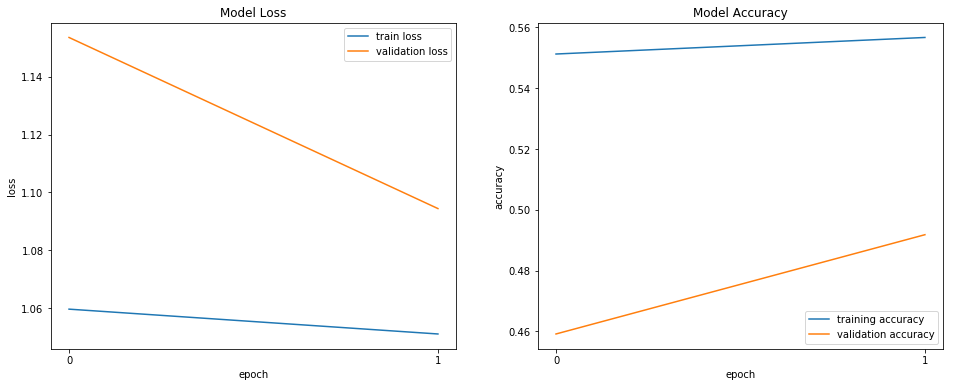

             precision    recall  f1-score   support

          3       0.00      0.00      0.00         4
          4       0.00      0.00      0.00        16
          5       0.50      0.64      0.56       163
          6       0.49      0.57      0.52       213
          7       0.52      0.19      0.28        78
          8       0.00      0.00      0.00        16

avg / total       0.46      0.49      0.46       490

490/490 [==============================] - 0s 74us/step


/home/stefano/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0 : Validation Accuracy =  0.491836734451




After binary encoding y:  (4408, 10)
xTrain:  (4408, 11)
yTrain:  (4408, 10)
xVal:  (490, 11)
yVal:  (490, 10)
Train on 4408 samples, validate on 490 samples
Epoch 1/2
4408/4408 [==============================] - 2s 347us/step - loss: 1.0494 - acc: 0.5597 - categorical_accuracy: 0.5597 - val_loss: 1.4087 - val_acc: 0.4592 - val_categorical_accuracy: 0.4592
Epoch 2/2
4408/4408 [==============================] - 1s 228us/step - loss: 1.0435 - acc: 0.5619 - categorical_accuracy: 0.5619 - val_loss: 1.2368 - val_acc: 0.4939 - val_categorical_accuracy: 0.4939


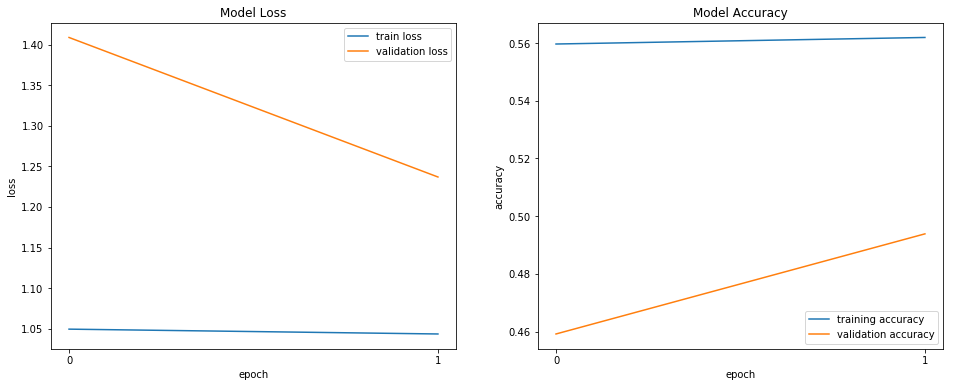

             precision    recall  f1-score   support

          3       0.00      0.00      0.00         2
          4       1.00      0.11      0.19        19
          5       0.60      0.68      0.63       148
          6       0.45      0.70      0.54       191
          7       0.30      0.06      0.10       105
          8       0.00      0.00      0.00        21
          9       0.00      0.00      0.00         4

avg / total       0.46      0.49      0.43       490

490/490 [==============================] - 0s 96us/step
1 : Validation Accuracy =  0.49387755102




After binary encoding y:  (4408, 10)
xTrain:  (4408, 11)
yTrain:  (4408, 10)
xVal:  (490, 11)
yVal:  (490, 10)
Train on 4408 samples, validate on 490 samples
Epoch 1/2
4408/4408 [==============================] - 1s 295us/step - loss: 1.0493 - acc: 0.5603 - categorical_accuracy: 0.5603 - val_loss: 1.1628 - val_acc: 0.4857 - val_categorical_accuracy: 0.4857
Epoch 2/2
4408/4408 [==============================] - 1s 22

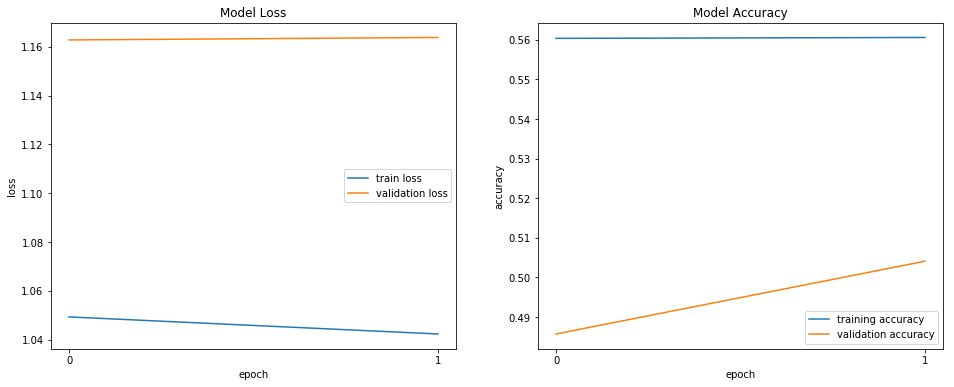

             precision    recall  f1-score   support

          3       0.00      0.00      0.00         3
          4       0.57      0.18      0.28        22
          5       0.50      0.71      0.59       137
          6       0.49      0.63      0.55       206
          7       0.62      0.17      0.26        96
          8       0.00      0.00      0.00        26

avg / total       0.49      0.50      0.46       490

490/490 [==============================] - 0s 73us/step
2 : Validation Accuracy =  0.50408163314




After binary encoding y:  (4408, 10)
xTrain:  (4408, 11)
yTrain:  (4408, 10)
xVal:  (490, 11)
yVal:  (490, 10)
Train on 4408 samples, validate on 490 samples
Epoch 1/2
4408/4408 [==============================] - 1s 303us/step - loss: 1.0648 - acc: 0.5526 - categorical_accuracy: 0.5526 - val_loss: 1.0568 - val_acc: 0.5796 - val_categorical_accuracy: 0.5796
Epoch 2/2
4408/4408 [==============================] - 1s 230us/step - loss: 1.0598 - acc: 0.5544 - categorical_a

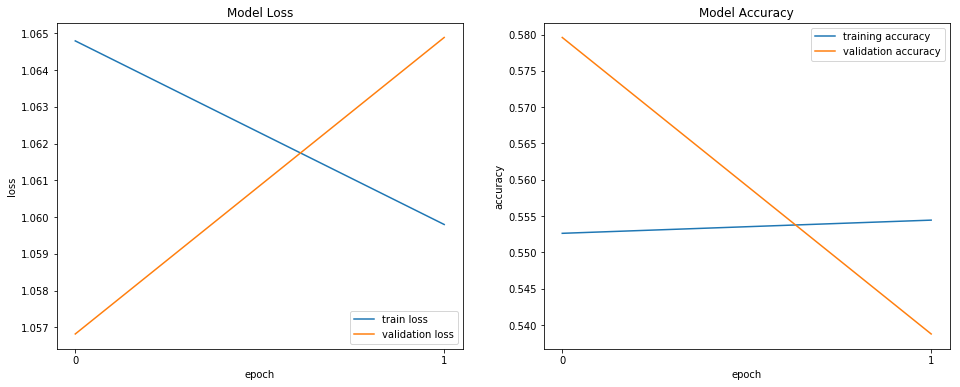

             precision    recall  f1-score   support

          3       0.00      0.00      0.00         3
          4       0.00      0.00      0.00        21
          5       0.52      0.70      0.60       152
          6       0.56      0.68      0.61       228
          7       0.40      0.03      0.05        74
          8       0.00      0.00      0.00        11
          9       0.00      0.00      0.00         1

avg / total       0.48      0.54      0.48       490

490/490 [==============================] - 0s 70us/step
3 : Validation Accuracy =  0.538775510326




After binary encoding y:  (4408, 10)
xTrain:  (4408, 11)
yTrain:  (4408, 10)
xVal:  (490, 11)
yVal:  (490, 10)
Train on 4408 samples, validate on 490 samples
Epoch 1/2
4408/4408 [==============================] - 1s 307us/step - loss: 1.0569 - acc: 0.5578 - categorical_accuracy: 0.5578 - val_loss: 1.0242 - val_acc: 0.5592 - val_categorical_accuracy: 0.5592
Epoch 2/2
4408/4408 [==============================] - 1s 2

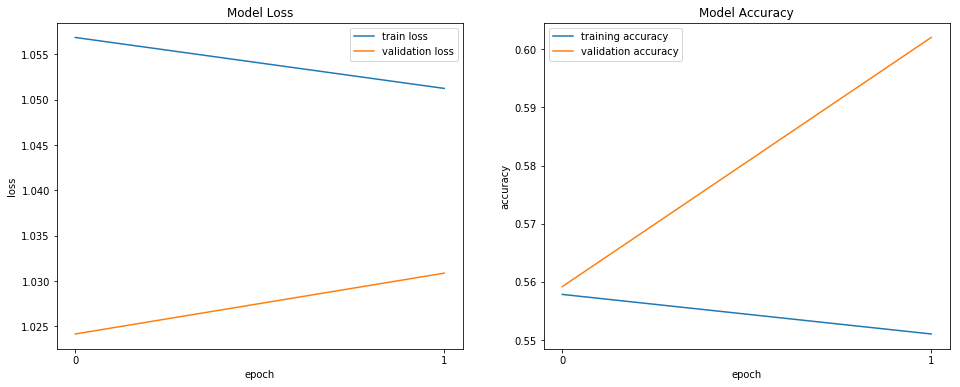

             precision    recall  f1-score   support

          3       0.00      0.00      0.00         2
          4       0.00      0.00      0.00        27
          5       0.68      0.65      0.66       202
          6       0.54      0.77      0.63       195
          7       0.78      0.27      0.41        51
          8       0.00      0.00      0.00        13

avg / total       0.58      0.60      0.57       490

490/490 [==============================] - 0s 68us/step
4 : Validation Accuracy =  0.60204081657




After binary encoding y:  (4408, 10)
xTrain:  (4408, 11)
yTrain:  (4408, 10)
xVal:  (490, 11)
yVal:  (490, 10)
Train on 4408 samples, validate on 490 samples
Epoch 1/2
4408/4408 [==============================] - 1s 306us/step - loss: 1.0625 - acc: 0.5499 - categorical_accuracy: 0.5499 - val_loss: 0.9766 - val_acc: 0.5755 - val_categorical_accuracy: 0.5755
Epoch 2/2
4408/4408 [==============================] - 1s 225us/step - loss: 1.0524 - acc: 0.5551 - categorical_a

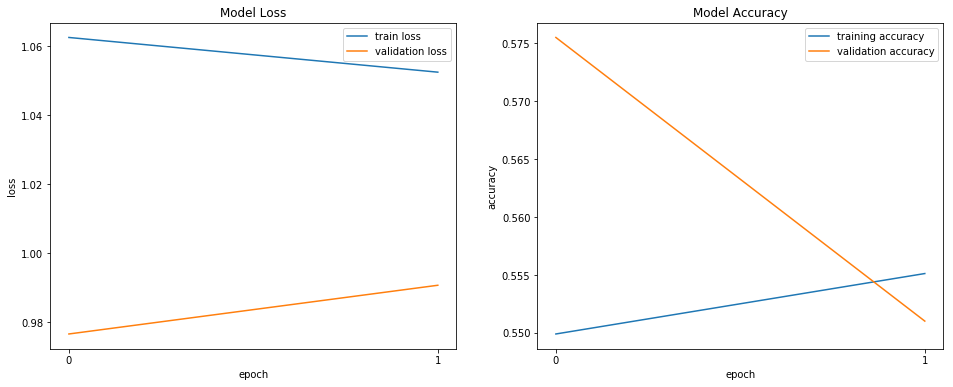

             precision    recall  f1-score   support

          4       0.25      0.08      0.12        12
          5       0.61      0.72      0.66       163
          6       0.48      0.63      0.55       192
          7       0.74      0.30      0.43       102
          8       0.00      0.00      0.00        21

avg / total       0.55      0.55      0.53       490

490/490 [==============================] - 0s 66us/step
5 : Validation Accuracy =  0.551020408285




After binary encoding y:  (4408, 10)
xTrain:  (4408, 11)
yTrain:  (4408, 10)
xVal:  (490, 11)
yVal:  (490, 10)
Train on 4408 samples, validate on 490 samples
Epoch 1/2
4408/4408 [==============================] - 1s 317us/step - loss: 1.0541 - acc: 0.5615 - categorical_accuracy: 0.5615 - val_loss: 1.1413 - val_acc: 0.5245 - val_categorical_accuracy: 0.5245
Epoch 2/2
4408/4408 [==============================] - 1s 226us/step - loss: 1.0486 - acc: 0.5558 - categorical_accuracy: 0.5558 - val_loss: 1.0760 - val_acc: 0.5429

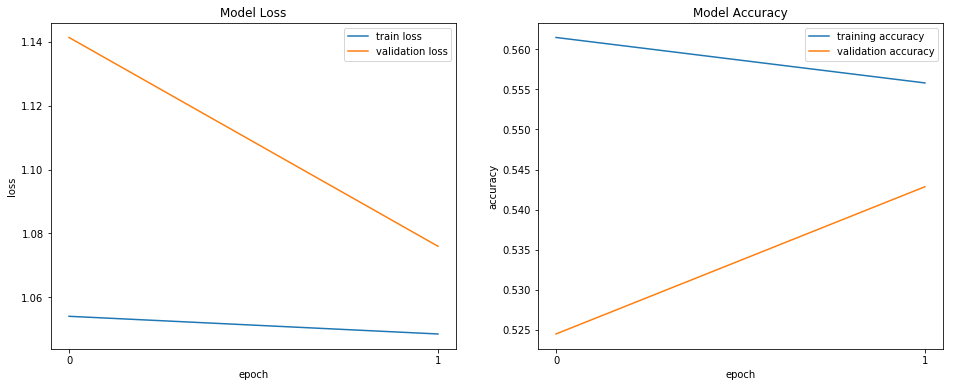

             precision    recall  f1-score   support

          3       0.00      0.00      0.00         4
          4       0.00      0.00      0.00         9
          5       0.52      0.36      0.43        99
          6       0.57      0.74      0.64       241
          7       0.48      0.46      0.47       112
          8       0.00      0.00      0.00        25

avg / total       0.50      0.54      0.51       490

490/490 [==============================] - 0s 85us/step
6 : Validation Accuracy =  0.542857142979




After binary encoding y:  (4408, 10)
xTrain:  (4408, 11)
yTrain:  (4408, 10)
xVal:  (490, 11)
yVal:  (490, 10)
Train on 4408 samples, validate on 490 samples
Epoch 1/2
4408/4408 [==============================] - 1s 321us/step - loss: 1.0613 - acc: 0.5563 - categorical_accuracy: 0.5563 - val_loss: 0.9579 - val_acc: 0.6469 - val_categorical_accuracy: 0.6469
Epoch 2/2
4408/4408 [==============================] - 1s 226us/step - loss: 1.0555 - acc: 0.5576 - categorical_

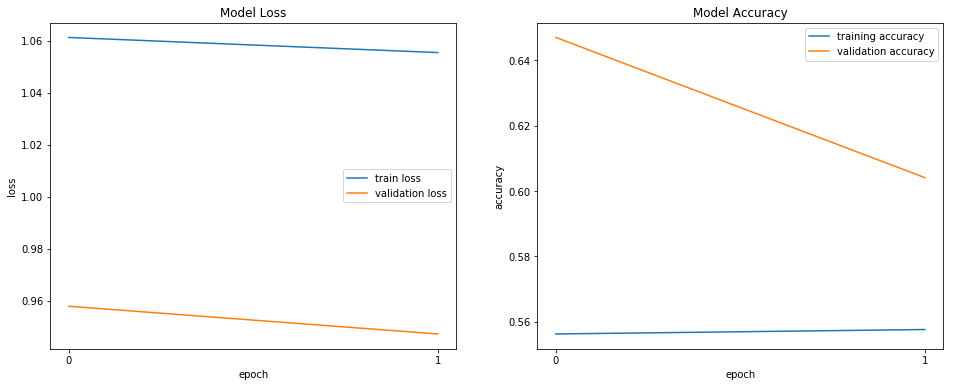

             precision    recall  f1-score   support

          3       0.00      0.00      0.00         1
          4       0.80      0.33      0.47        12
          5       0.68      0.65      0.66       127
          6       0.57      0.78      0.66       216
          7       0.59      0.37      0.45       112
          8       0.00      0.00      0.00        22

avg / total       0.58      0.60      0.58       490

490/490 [==============================] - 0s 69us/step
7 : Validation Accuracy =  0.60408163241




After binary encoding y:  (4408, 10)
xTrain:  (4408, 11)
yTrain:  (4408, 10)
xVal:  (490, 11)
yVal:  (490, 10)
Train on 4408 samples, validate on 490 samples
Epoch 1/2
4408/4408 [==============================] - 1s 335us/step - loss: 1.0723 - acc: 0.5467 - categorical_accuracy: 0.5467 - val_loss: 0.9914 - val_acc: 0.5878 - val_categorical_accuracy: 0.5878
Epoch 2/2
4408/4408 [==============================] - 1s 225us/step - loss: 1.0681 - acc: 0.5533 - categorical_a

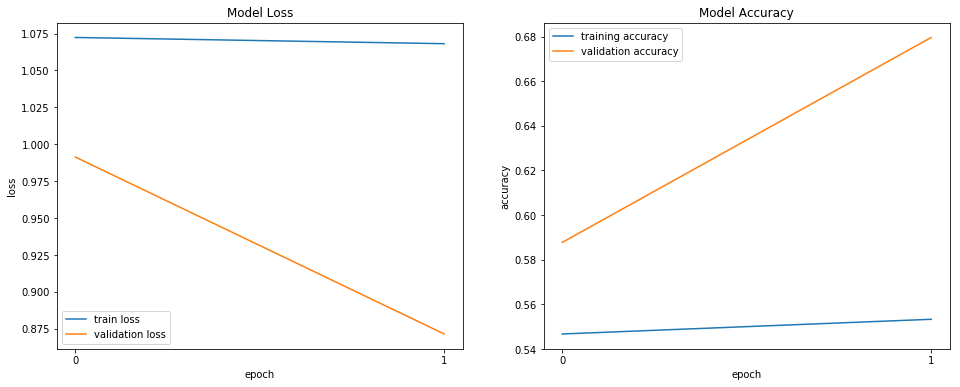

             precision    recall  f1-score   support

          4       0.75      0.20      0.32        15
          5       0.72      0.63      0.67       150
          6       0.65      0.86      0.74       237
          7       0.79      0.45      0.57        73
          8       0.00      0.00      0.00        15

avg / total       0.67      0.68      0.66       490

490/490 [==============================] - 0s 67us/step
8 : Validation Accuracy =  0.679591836248




After binary encoding y:  (4410, 10)
xTrain:  (4410, 11)
yTrain:  (4410, 10)
xVal:  (488, 11)
yVal:  (488, 10)
Train on 4410 samples, validate on 488 samples
Epoch 1/2
4410/4410 [==============================] - 1s 331us/step - loss: 1.0624 - acc: 0.5592 - categorical_accuracy: 0.5592 - val_loss: 0.8902 - val_acc: 0.6127 - val_categorical_accuracy: 0.6127
Epoch 2/2
4410/4410 [==============================] - 1s 225us/step - loss: 1.0579 - acc: 0.5578 - categorical_accuracy: 0.5578 - val_loss: 0.9140 - val_acc: 0.5820

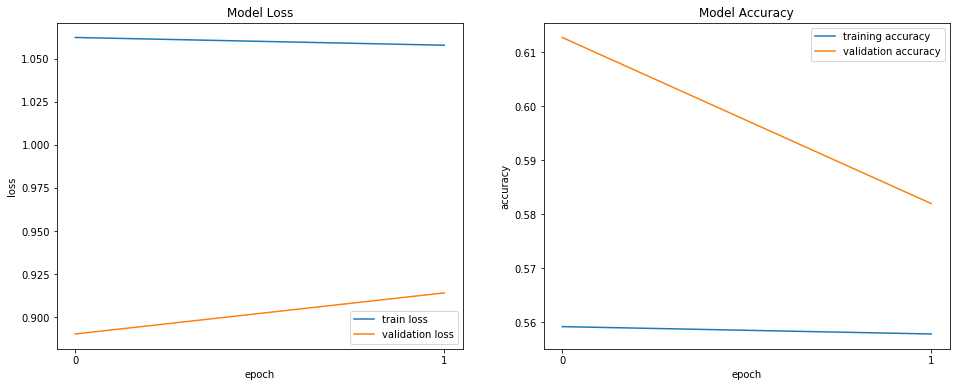

             precision    recall  f1-score   support

          3       0.00      0.00      0.00         1
          4       0.40      0.20      0.27        10
          5       0.58      0.51      0.54       116
          6       0.66      0.68      0.67       279
          7       0.35      0.43      0.39        77
          8       0.00      0.00      0.00         5

avg / total       0.58      0.58      0.58       488

488/488 [==============================] - 0s 69us/step
9 : Validation Accuracy =  0.581967213115






In [13]:


validationAccuracies = []
k = 10
for i in range(k):
    
    # Create new model for this fold
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy', 'categorical_accuracy'])
#     model.summary()
    
    # Split the data
    xTrain, yTrain, xVal, yVal = splitAndOverSample(X, y, k, i)
#     xTrain, yTrain, xVal, yVal = splitAndOverSample(X, y)
    print("xTrain: ", xTrain.shape)
    print("yTrain: ", yTrain.shape)
    print("xVal: ", xVal.shape)
    print("yVal: ", yVal.shape)

    # Train the model
    model.fit(xTrain, yTrain, validation_data=(xVal, yVal), epochs=2, callbacks=[pltCallBack])
    pltCallBack.show_plots()

#     Predict the validation set
    predictions = model.predict(xVal)
    

    # Extract the predicted categories
    predictionsCat = np.argmax(predictions, axis=1)
    yValCat = np.argmax(yVal, axis=1)
    
#     print(predictionsCat)
#     print(yVal)
    
#     print(confusion_matrix(yValCat, predictionsCat))

        
    print(classification_report(yValCat, predictionsCat))

    # Plot histogram of predicted category distribution
#     plt.hist(predictionCat, bins=range(3, 11), align='left', rwidth=0.5)
#     plt.show()

    # print("Actual: ")
    # print(yVal[0], "\n")

    #     # evaluate the model
    scores = model.evaluate(xVal, yVal)
    print(i, ": Validation Accuracy = ", scores[1])
    validationAccuracies.append(scores[1])
    
    print("\n\n\n")
    

In [ ]:
print("Mean Validation Accuracy accross ", k, ", folds: ", np.mean(validationAccuracies))


testScores = model.evaluate(xTest, yTest)
    print("Accuracy on Test set = ", testScores[1])